Домашнее задание

1.В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

2.Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Реализация дерева решений

Реализуем алгоритм алгоритм работы дерева решений своими руками.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [40]:
# сгенерируем данные
regression_data, regression_labels = datasets.make_regression(n_samples = 1000,
                                                                   n_features = 2, n_targets=1,
                                                              noise= 1, 
                                                                   shuffle=True,
                                                                   n_informative = 2, 
                                                                   random_state=5)

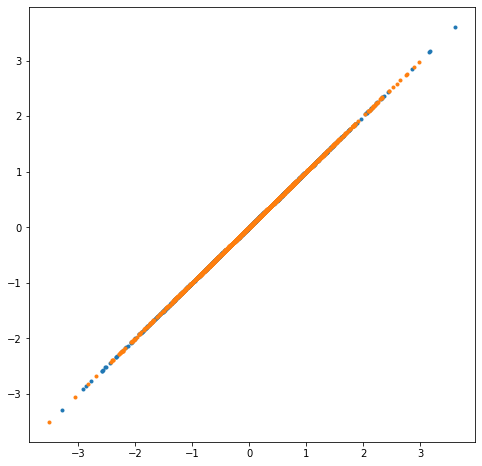

In [41]:
# визуализируем сгенерированные данные

plt.figure(figsize=(8,8))
plt.plot(regression_data,regression_data,'.' )
plt.show()

# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(16,8))
plt.scatter(list(map(lambda x: x[0], regression_data)), list(map(lambda x: x[1], regression_data)), 
              c=regression_labels, cmap=colors)
plt.show()

In [42]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [43]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data # значения признаков
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction

In [44]:
# Расчет дисперсии - как критерия нечистоты

def gini(labels):
    impurity = np.var(labels)     # "impurity" - "нечистота", степень неопределенности       
    return impurity

In [45]:
# float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

In [46]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels) # Функционал качества

In [47]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [48]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels) 

    best_quality = 0
    best_t = None # лучший порог разбиения
    best_index = None # лучший индекс разбиения
    
    n_features = data.shape[1] # кол-во признаков
    
    for index in range(n_features): # проход по всем признакам
        t_values = [row[index] for row in data] # берем столбец/признак с соотв. индексом
        
        for t in t_values: # проход по признаку
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t) # делаем разбиение
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue # начинаем следующий проход цикла, минуя оставшееся тело цикла
            
            # расчет качества текущего разбиения
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [49]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth, current_depth):
    if (current_depth >=max_depth):
        return Leaf(data, labels)
    quality, t, index = find_best_split(data, labels) # ищем лучшее разбиение
#     print(quality, t, index)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    # неопределенность после разбиения осталась такой же как до
    if quality == 0: # критерий останова
#         print('leaf')
        return Leaf(data, labels) # считаем прогноз для листьев

    # если качество улучшилось, то делим дерево по лучшему разбиению
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels,max_depth, current_depth+1)
    false_branch = build_tree(false_data, false_labels,max_depth, current_depth+1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [50]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): # проверка текущий узел это лист?
        answer = node.prediction # считаем прогноз для листа
        return answer

    if obj[node.index] <= node.t: # если значение признака меньше порога t
        return classify_object(obj, node.true_branch) # рекурсия: отправляем объект в true-ветку
    else:
        return classify_object(obj, node.false_branch) # рекурсия: отправляем объект в false-ветку

In [51]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree) # определяем ветки для объектов
        classes.append(prediction)
    return classes

In [52]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(regression_data, 
                                                                                     regression_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [85]:
# Построим дерево по обучающей выборке

max_depth =5#параметр -  максимальной глубины дерева
# 0 - это текущая глубина дерева
my_tree = build_tree(train_data, train_labels, max_depth, 0)
print(my_tree)
display(my_tree.index, my_tree.t, my_tree.true_branch , my_tree.false_branch)

0

0.07045426598702902

In [86]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.07045426598702902
--> True:
  Индекс 1
  Порог -0.14453465978140453
  --> True:
    Индекс 0
    Порог -0.8413727621042622
    --> True:
      Индекс 1
      Порог -0.691197085132304
      --> True:
        Индекс 0
        Порог -2.068894814273062
        --> True:
          Прогноз: -202.86015721863342
        --> False:
          Прогноз: -142.98747713997332
      --> False:
        Индекс 0
        Порог -1.4572192335456116
        --> True:
          Прогноз: -129.12562997460697
        --> False:
          Прогноз: -90.10757232312635
    --> False:
      Индекс 1
      Порог -1.0783457311032987
      --> True:
        Индекс 1
        Порог -1.5821319551568154
        --> True:
          Прогноз: -122.89018487566211
        --> False:
          Прогноз: -90.37078034284156
      --> False:
        Индекс 0
        Порог -0.5265079987444812
        --> True:
          Прогноз: -68.11667769578558
        --> False:
          Прогноз: -41.9970013443232
  --> False:
 

In [87]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
train_answers[:5]

[97.44141065317432,
 31.367084628906255,
 -13.841800195648807,
 -41.9970013443232,
 24.649848605925442]

In [88]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

Accuracy = расчет *доли правильных ответов*:

$$accuracy(a,x) = \frac{1}{l} \sum^{l}_{i=1}[a(x_{i})=y_{i}].$$

In [89]:
# Введем функцию подсчета точности как доли правильных ответов
def mse_metric(actual, predicted):
    mse = 0
    for i in range(len(actual)):
        mse = mse + (actual[i] - predicted[i])**2
    return mse / float(len(actual))

In [90]:
# Точность на обучающей выборке
train_mse = mse_metric(train_labels, train_answers)
train_mse

356.34295670532384

In [91]:
# Точность на тестовой выборке
test_mse = mse_metric(test_labels, answers)
test_mse

620.0511153079991

In [92]:
from sklearn.tree import DecisionTreeRegressor

In [93]:
reg = DecisionTreeRegressor(random_state=0, max_depth=5
                           )
reg.fit(train_data, train_labels)


DecisionTreeRegressor(max_depth=5, random_state=0)

In [94]:
# Точность на обучающей выборке
train_mse_s = mse_metric(train_labels,reg.predict(train_data))
train_mse_s,train_mse

(342.15295488435567, 356.34295670532384)

In [95]:
# Точность на тестовой выборке
test_mse_s = mse_metric(test_labels,reg.predict(test_data))
test_mse_s,test_mse

(587.8579831200801, 620.0511153079991)

[Text(169.59375, 201.90857142857143, 'X[0] <= 0.072\nmse = 6068.224\nsamples = 700\nvalue = 0.838'),
 Text(86.4, 170.84571428571428, 'X[1] <= -0.141\nmse = 3796.488\nsamples = 355\nvalue = -47.751'),
 Text(43.2, 139.78285714285715, 'X[0] <= -0.84\nmse = 2203.322\nsamples = 170\nvalue = -90.613'),
 Text(21.6, 108.72, 'X[1] <= -0.683\nmse = 1687.535\nsamples = 68\nvalue = -129.327'),
 Text(10.8, 77.65714285714284, 'X[0] <= -2.032\nmse = 1527.949\nsamples = 37\nvalue = -152.697'),
 Text(5.4, 46.59428571428572, 'X[0] <= -2.924\nmse = 495.097\nsamples = 6\nvalue = -202.86'),
 Text(2.7, 15.531428571428563, 'mse = 0.0\nsamples = 1\nvalue = -244.154'),
 Text(8.100000000000001, 15.531428571428563, 'mse = 184.875\nsamples = 5\nvalue = -194.601'),
 Text(16.200000000000003, 46.59428571428572, 'X[1] <= -1.924\nmse = 1146.547\nsamples = 31\nvalue = -142.987'),
 Text(13.5, 15.531428571428563, 'mse = 846.658\nsamples = 5\nvalue = -200.007'),
 Text(18.900000000000002, 15.531428571428563, 'mse = 458.752

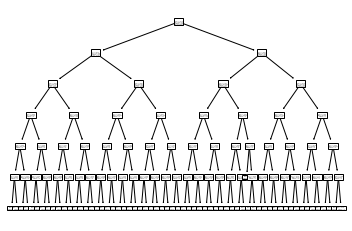

In [64]:
from sklearn import tree
tree.plot_tree(reg) 

## Дополнительные материалы

1. [Энтропия](https://habr.com/ru/post/305794/)
2. [Энтропия - теоретическое обоснование](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F)
3. [Cost-Complexity Pruning](http://mlwiki.org/index.php/Cost-Complexity_Pruning)
4. [Реализация дерева решений в функциональном стиле](https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb)
5. [ООП-реализация дерева решений](https://github.com/curiousily/Machine-Learning-from-Scratch/blob/master/3_decision_trees.ipynb)
6. [Пример работы дерева решений в задаче регрессии](https://habr.com/ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii)

## Summary

* Решающее дерево - последовательное построение узлов, разбивающих множество входящих объектов согласно принципу минимизации “нечистоты” (impurity) узла
* Предикаты для разбиения в узле выбираются из всего множества признаков
* Деревья могут легко переобучиться под выборку, если не ограничивать их глубину
* Деревья очень чувствительны к небольшим изменениям в выборке (шумам)

## Домашнее задание


1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)
2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.